**Dimensionless arrival time of bus $i$ at the origin (for $i = 1, 2$)**

$$
T_i(m+1) = T_i(m) + \Gamma \left( T_i(m) - T_i'(m') \right) + \frac{1}{1 + S_i \left( T_i(m) - T_i'(m') \right)}
$$

- $\Gamma$: Loading parameter  
- $S_i$: Speedup parameter  
- $T_i(m)$: The arrival time of bus $i$ at trip $m$ at the origin  
- $T_i'(m')$: The arrival time of the other bus $i'$ at trip $m'$ at the origin ($i'$ leave right before $i$)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 1. Data Structure to store information about trip

In [2]:
def simulate_bus_system(T1_initial=1, T2_initial=2.5, gamma=1, S1=0, S2=0, num_trips=1000):
    """
    Simulates a two-bus transportation system based on the following recurrence relation:
        T_i(m+1) = T_i(m) + Γ * (T_i(m) - T_i'(m')) + 1 / (1 + S_i * (T_i(m) - T_i'(m')))

    Parameters:
    - T1_initial, T2_initial: Initial departure times of bus 1 and bus 2 from the origin, respectively.
    - gamma (Γ): Load sensitivity parameter affecting the spacing between trips.
    - S1, S2: Speedup parameters for bus 1 and bus 2, respectively.
    - num_trips: Total number of trips to simulate for each bus.

    Returns:
    - A list of trips in the format [time, bus_number, trip_number, used_flag], where:
        - time: Time at which a bus arrives at the origin.
        - bus_number: Bus identifier (1 or 2).
        - trip_number: Sequence number of the trip for the corresponding bus.
        - used_flag: Boolean flag indicating whether the trip was used in computing the next trip.
    """

    arrival_time = [
        [0, 2, -1, False],           # Bias entry
        [T1_initial, 1, 0, False]   # First trip of bus 1
    ]
    
    temp_time = [None, T2_initial]                        # [time for bus 1, time for bus 2]
    temp_trip = [None, [T2_initial, 2, 0, False]]         # [record for bus 1, record for bus 2]
    count_trip = [0, 0]                                   # Already have first trip for each bus
    i = 1
    while count_trip[0] < num_trips + 1 or count_trip[1] < num_trips + 1:
        if i >= len(arrival_time):
            break
        
        current_row = arrival_time[i] # Current trip need to process
        
        if current_row[2] == -1 or current_row[3]:
            i += 1
            continue

        bus_id = current_row[1]

        # Find previous active bus (used_flag = False)
        for j in range(i - 1, -1, -1):
            if not arrival_time[j][3]:
                pre_row = arrival_time[j]
                break

        # Calculate the next arrival time at the origin
        delta = current_row[0] - pre_row[0]
        if delta < 0:
            print(f"Check again !!, delta < 0 at gamma = {gamma} and S1 = {S1}, S2 = {S2}")

        S = S1 if bus_id == 1 else S2
        
        # Calculate next arrival time at the origin
        next_time = current_row[0] + gamma * delta + 1 / (1 + S * delta)

        # Update
        pre_row[3] = True
        temp_time[bus_id - 1] = next_time
        temp_trip[bus_id - 1] = [next_time, bus_id, current_row[2] + 1, False]

        # Choose bus arrive before and add to arrival_time
        if temp_time[0] is not None and temp_time[1] is not None:
            if temp_time[0] < temp_time[1]:
                arrival_time.append(temp_trip[0])
                count_trip[0] += 1
                temp_time[0], temp_trip[0] = None, None
            else:
                arrival_time.append(temp_trip[1])
                count_trip[1] += 1
                temp_time[1], temp_trip[1] = None, None
        i += 1

    return arrival_time

In [3]:
arrival_time = simulate_bus_system(1, 2.5, 0.5, 1.1, 1.1, 1000)

In [4]:
import pandas as pd
df = pd.DataFrame(arrival_time, columns = ['Time', 'bus', 'trip', 'Flag'])
print(df)

            Time  bus  trip   Flag
0       0.000000    2    -1   True
1       1.000000    1     0   True
2       1.976190    1     1   True
3       2.500000    2     0   True
4       2.946490    1     2   True
...          ...  ...   ...    ...
1999  904.045927    2   998   True
2000  904.297193    1  1000   True
2001  904.955018    2   999   True
2002  905.206284    1  1001  False
2003  905.864108    2  1000  False

[2004 rows x 4 columns]


In [5]:
def data_for_plot(func, T1_initial, T2_initial, S1, S2, num_trips=1000):
    x_vals, y_vals = [], []

    for gamma in np.linspace(0, 2, 2000):
        arrival_time = simulate_bus_system(T1_initial, T2_initial, gamma, S1, S2, num_trips)

        arrival_time_1 = np.array([t[0] for t in arrival_time if t[1] == 1 and 900 <= t[2] < 1001])
        arrival_time_2 = np.array([t[0] for t in arrival_time if t[1] == 2 and 900 <= t[2] < 1001])

        # Calculate tour time
        T1 = np.diff(arrival_time_1)
        T2 = np.diff(arrival_time_2)

        # Headway of bus 1
        H1 = [arrival_time[i][0] - arrival_time[i-1][0]
              for i in range(1, len(arrival_time))
              if arrival_time[i][1] == 1 and 900 <= arrival_time[i][2] <= 1000]

        if func == "Headway of bus 1":
            x_vals.extend([gamma] * len(H1))
            y_vals.extend(H1)
        elif func == "Tour time of bus 1":
            x_vals.extend([gamma] * len(T1))
            y_vals.extend(T1)
        elif func == "Tour time of bus 2":
            x_vals.extend([gamma] * len(T2))
            y_vals.extend(T2)

    return x_vals, y_vals


# 2. Plot

### 2.1. Plots of the time headway $H_1(m)$ of bus 1 against loading parameter $\Gamma$
We analyze the time headway $H_1(m)$ of bus 1 for sufficiently large trips $m = 900$ to $1000$, to observe the system's steady-state behavior under different loading conditions. <br> Diagrams (a)–(d) are generated under the following settings:

(a) $S_1 = S_2 = 0$ <br> (b) $S_1 = S_2 = 0.2$ <br> (c) $S_1 = 0.3$, $S_2 = 0.2$ <br> (d) $S_1 = 0.5$, $S_2 = 0.2$

In [6]:
def plot_headway(configs, T1_initial, T2_initial, num_trips, xlim, ylim):
    plt.figure(figsize=(15, 10))

    for i, (S1, S2, title) in enumerate(configs, 1):
        plt.subplot(2, 2, i)
        x, y = data_for_plot("Headway of bus 1", T1_initial, T2_initial, S1, S2, num_trips)
        plt.scatter(x, y, s=1, alpha=0.5)
        plt.xlabel("Loading parameter", fontsize=12)
        plt.ylabel("Headway of bus 1", fontsize=12)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

In [7]:
# Initialization
T1_initial = 1
T2_initial = 2.5
num_trips = 1000

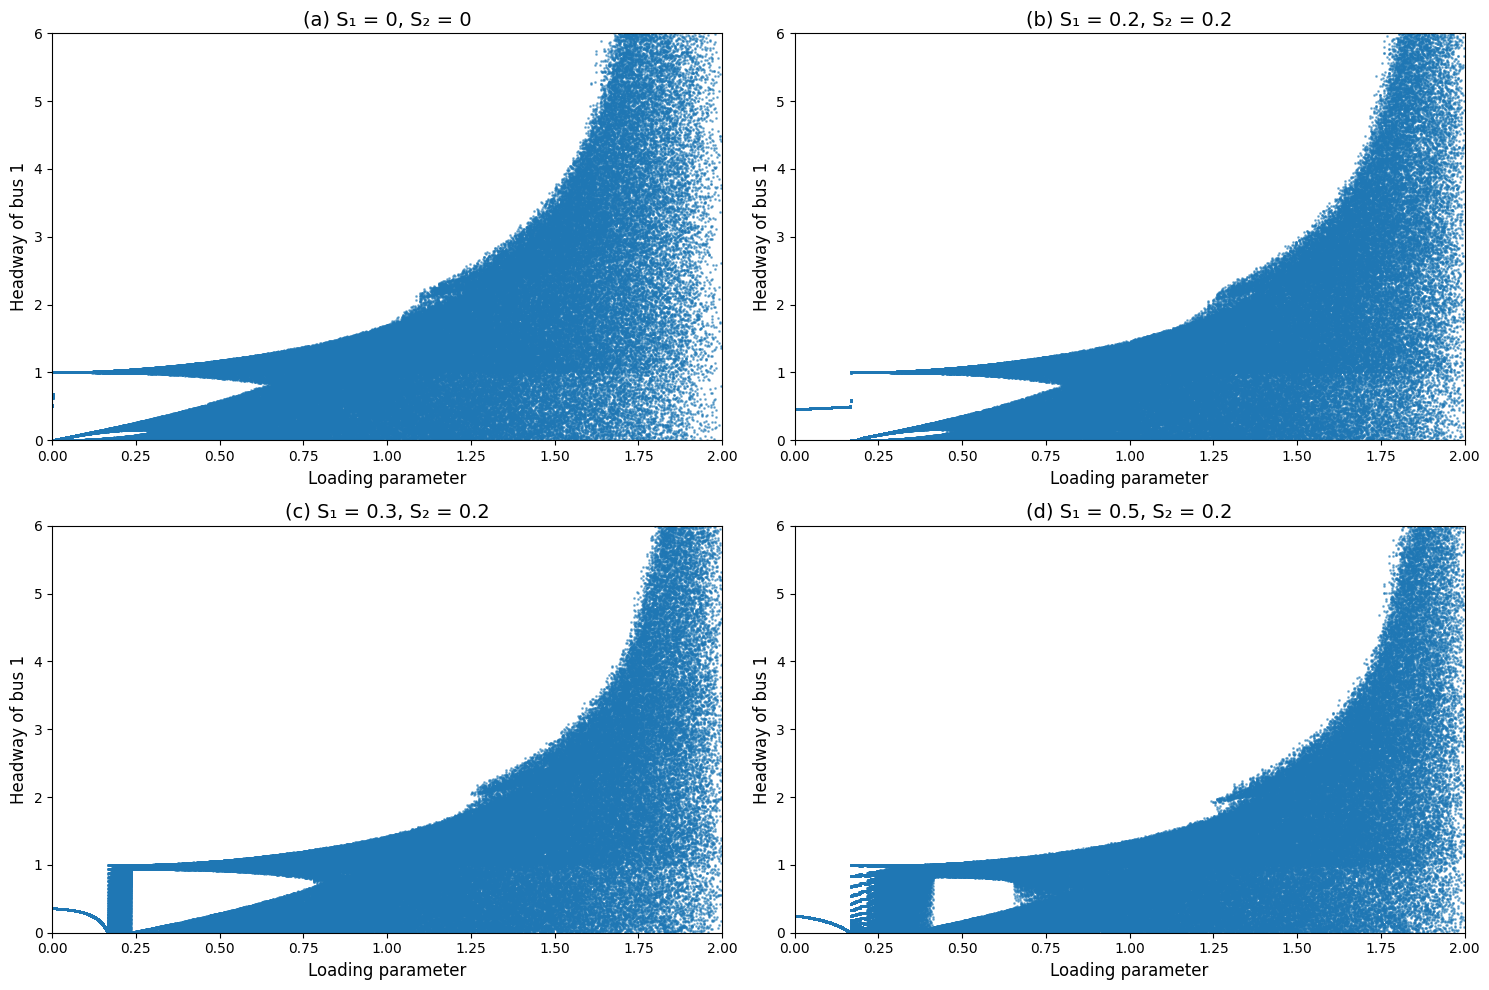

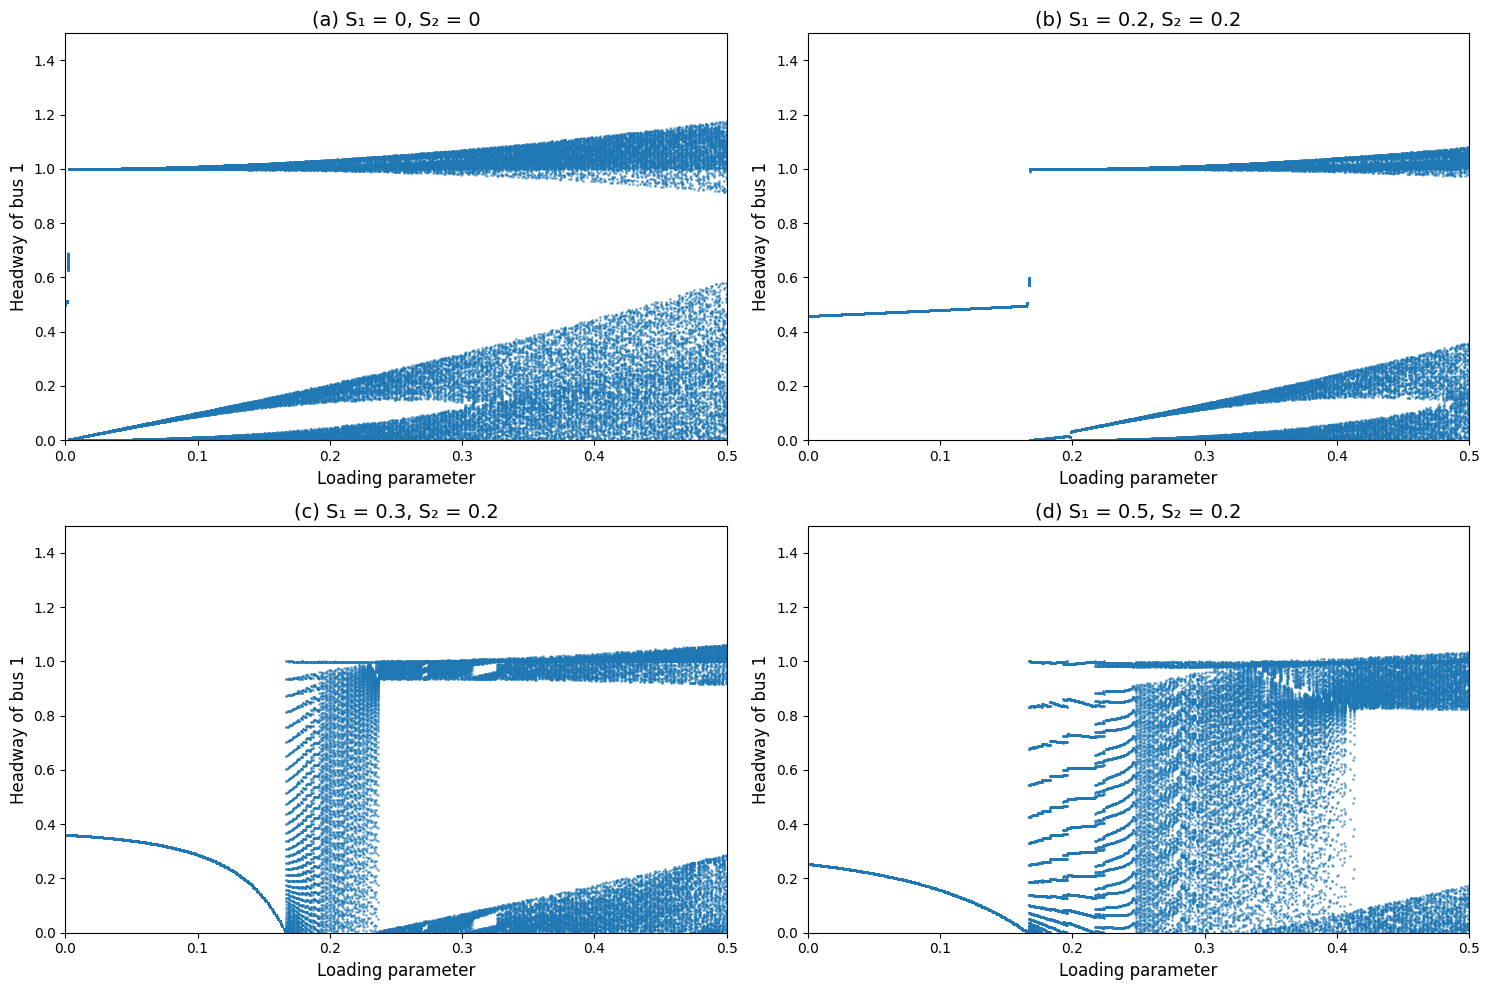

In [8]:
configs = [
    (0, 0, "(a) S₁ = 0, S₂ = 0"),
    (0.2, 0.2, "(b) S₁ = 0.2, S₂ = 0.2"),
    (0.3, 0.2, "(c) S₁ = 0.3, S₂ = 0.2"),
    (0.5, 0.2, "(d) S₁ = 0.5, S₂ = 0.2"),
]

plot_headway(configs, T1_initial, T2_initial, num_trips, xlim=(0, 2), ylim=(0, 6))
plot_headway(configs, T1_initial, T2_initial, num_trips, xlim=(0, 0.5), ylim=(0, 1.5))

### 2.2. Plots of tour times of buses 1 and 2 against loading parameter $\Gamma$ for sufficiently large trips $m = 900$ to $1000$ for case $S_1 = 0.5$ and $S_2 = 0.2$

In [9]:
def plot_single_subplot(position, func, range_x, range_y, T1_initial, T2_initial, S1, S2, num_trips):
    plt.subplot(position)
    x, y = data_for_plot(func=func, T1_initial=T1_initial, T2_initial=T2_initial, S1=S1, S2=S2, num_trips=num_trips)
    plt.scatter(x, y, s=1, alpha=0.5)
    plt.xlabel("Loading parameter", fontsize=12)
    plt.ylabel(func, fontsize=12)
    plt.xlim(range_x)
    plt.ylim(range_y)
    plt.title(func, fontsize=14)


def plot_tour_time_subplots(funcs, range_x, range_y, fig_size=(15, 5), S1=0.5, S2=0.2, num_trips=1000):
    plt.figure(figsize=fig_size)
    for idx, func in enumerate(funcs, start=1):
        plot_single_subplot(120 + idx, func, range_x, range_y, T1_initial=1, T2_initial=2.5, S1=S1, S2=S2, num_trips=num_trips)
    plt.tight_layout()
    plt.show()


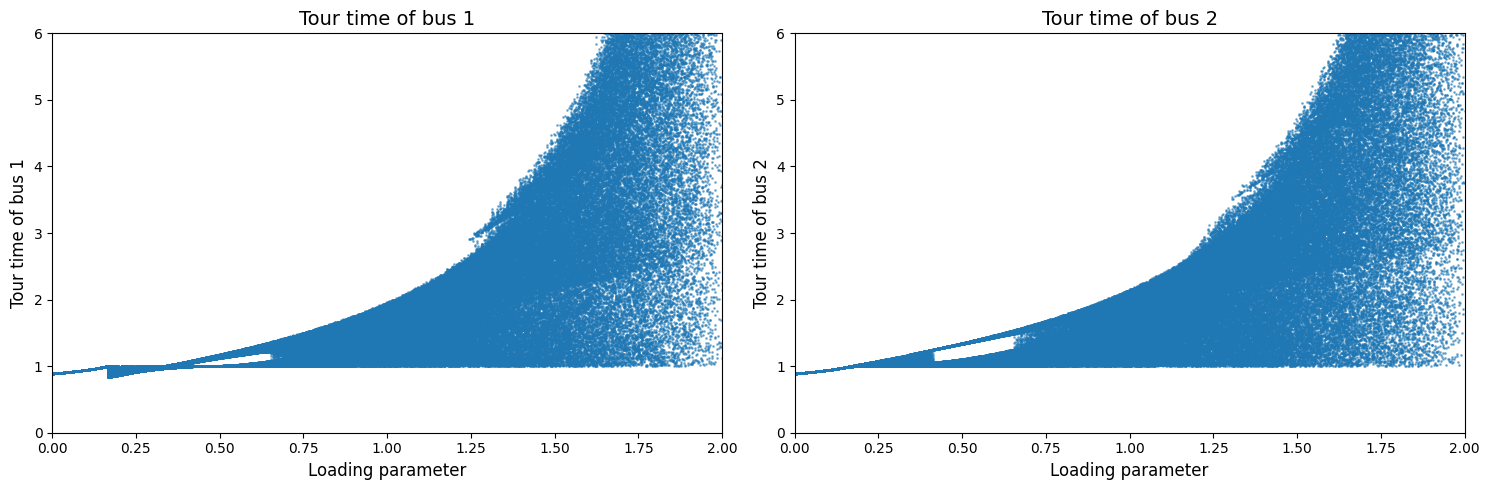

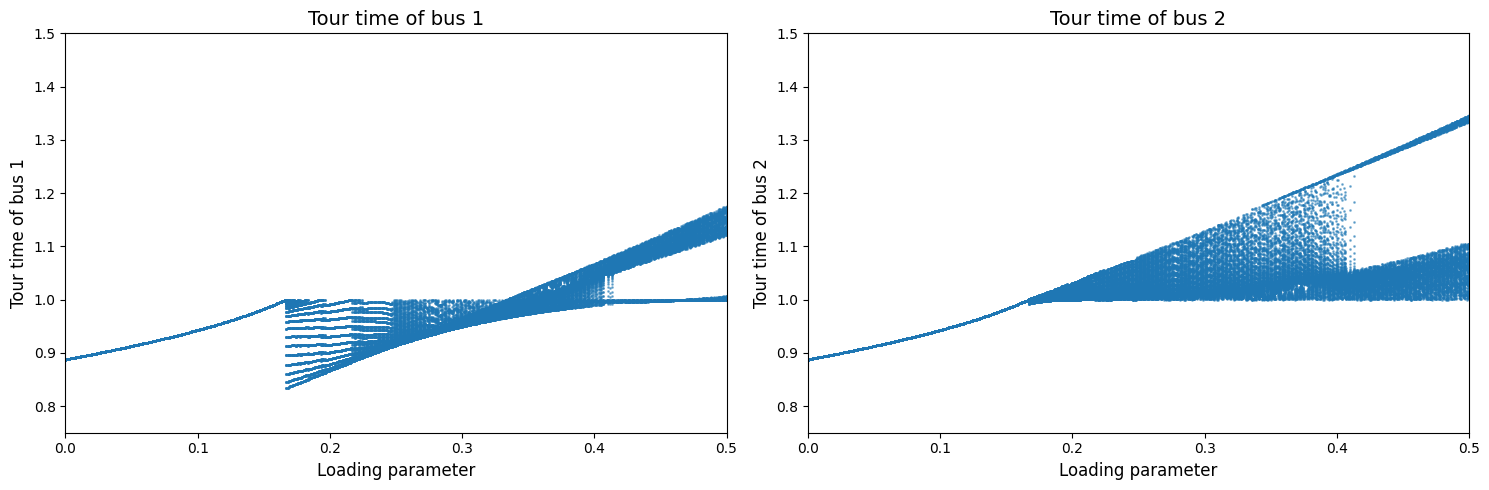

In [10]:
plot_tour_time_subplots(
    funcs=["Tour time of bus 1", "Tour time of bus 2"],
    range_x=(0, 2),
    range_y=(0, 6)
)

plot_tour_time_subplots(
    funcs=["Tour time of bus 1", "Tour time of bus 2"],
    range_x=(0, 0.5),
    range_y=(0.75, 1.5)
)

### 2.3. Plots of $H_1(m+1)$ against $H_1(m)$ for $m = 1000$ to $2000$ for case $S_1 = 0.5$ and $S_2 = 0.2$

In [11]:
plt.figure(figsize=(20, 8))

def plot_headway_vs_headway(num_plot, T1_initial, T2_initial, gamma, S1, S2, num_trips=2000):
    x_vals = []
    y_vals = []

    arrival_time = simulate_bus_system(T1_initial, T2_initial, gamma, S1, S2, num_trips)

    for i in range(len(arrival_time)):
        if arrival_time[i][1] == 1 and 1000 <= arrival_time[i][2] <= 2000:
            h_m = arrival_time[i][0] - arrival_time[i-1][0]
            h_m1 = arrival_time[i+1][0] - arrival_time[i][0]
            x_vals.append(h_m)
            y_vals.append(h_m1)

    plt.subplot(2, 2, num_plot)
    plt.scatter(x_vals, y_vals, s=2, alpha=0.5)
    plt.plot([0, 1.5], [0, 1.5], color='black', linestyle='-', linewidth=1)
    plt.xlabel("Headway at trip m", fontsize=10)
    plt.ylabel("Headway at trip m+1", fontsize=10)
    plt.xlim(0, 1.5)
    plt.ylim(0, 1.5)
    plt.title(f"Loading parameter: {gamma:.1f}")

<Figure size 2000x800 with 0 Axes>

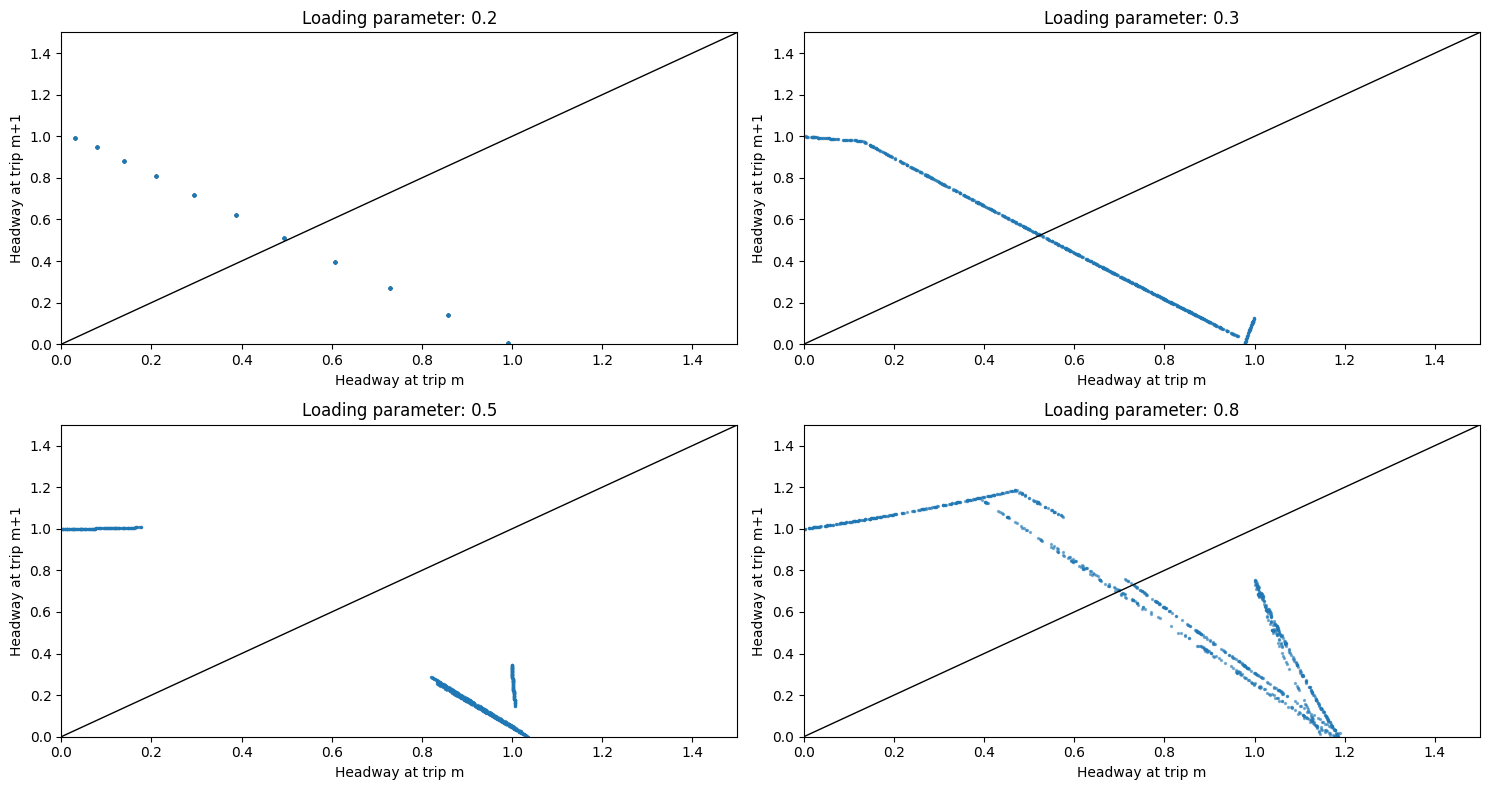

In [31]:
plt.figure(figsize=(15, 8))
for i, gamma in enumerate([0.2, 0.3, 0.5, 0.8], 1):
    plot_headway_vs_headway(i, T1_initial, T2_initial, gamma, S1=0.5, S2=0.2, num_trips=2000)
plt.tight_layout()
plt.show()


### 2.4. Plots of mean and standard deviation of headways $H_1, H_2$ and tour times $\Delta T_1$, $\Delta T_2$ against loading parameter $\Gamma$ for case $S_1 = 0.5$ and $S_2 = 0.2$

In [32]:
import numpy as np

x = []
h1_mean = []
h1_rms = []
h2_mean = []
h2_rms = []
t1_mean = []
t1_rms = []
t2_mean = []
t2_rms = []

for gamma in np.linspace(0, 2, 2000):
    arrival_time = simulate_bus_system(T1_initial = T1_initial, T2_initial = T2_initial, gamma = gamma, S1 = 0.5, S2 = 0.2, num_trips=2000)

    arrival_time_1 = np.array([t[0] for t in arrival_time if t[1] == 1 and 1000 <= t[2] <= 2000])
    arrival_time_2 = np.array([t[0] for t in arrival_time if t[1] == 2 and 1000 <= t[2] <= 2000])

    # Compute tour times
    T1 = np.abs(arrival_time_1[1:] - arrival_time_1[:-1]) if len(arrival_time_1) > 1 else np.array([])
    T2 = np.abs(arrival_time_2[1:] - arrival_time_2[:-1]) if len(arrival_time_2) > 1 else np.array([])

    T1_mean_val = np.mean(T1)
    T2_mean_val = np.mean(T2)
    T1_rms_val = np.sqrt(np.mean(np.square(T1 - T1_mean_val)))
    T2_rms_val = np.sqrt(np.mean(np.square(T2 - T2_mean_val)))

    # Compute headway
    H1 = []
    H2 = []
    for i in range(1, len(arrival_time)):
        if 1000 <= arrival_time[i][2] <= 2000:
            if arrival_time[i][1] == 1:
                H1.append(arrival_time[i][0] - arrival_time[i-1][0])
            elif arrival_time[i][1] == 2:
                H2.append(arrival_time[i][0] - arrival_time[i-1][0])

    H1_mean_val = np.mean(H1)
    H2_mean_val = np.mean(H2) 
    H1_rms_val = np.sqrt(np.mean(np.square(H1 - H1_mean_val)))
    H2_rms_val = np.sqrt(np.mean(np.square(H2 - H2_mean_val)))

    # Append all values to respective lists
    x.append(gamma)
    h1_mean.append(H1_mean_val)
    h1_rms.append(H1_rms_val)
    h2_mean.append(H2_mean_val)
    h2_rms.append(H2_rms_val)
    t1_mean.append(T1_mean_val)
    t2_mean.append(T2_mean_val)
    t1_rms.append(T1_rms_val)
    t2_rms.append(T2_rms_val)

x = np.array(x)
h1_mean = np.array(h1_mean)
h1_rms = np.array(h1_rms)
h2_mean = np.array(h2_mean)
h2_rms = np.array(h2_rms)
t1_mean = np.array(t1_mean)
t1_rms = np.array(t1_rms)
t2_mean = np.array(t2_mean)
t2_rms = np.array(t2_rms)


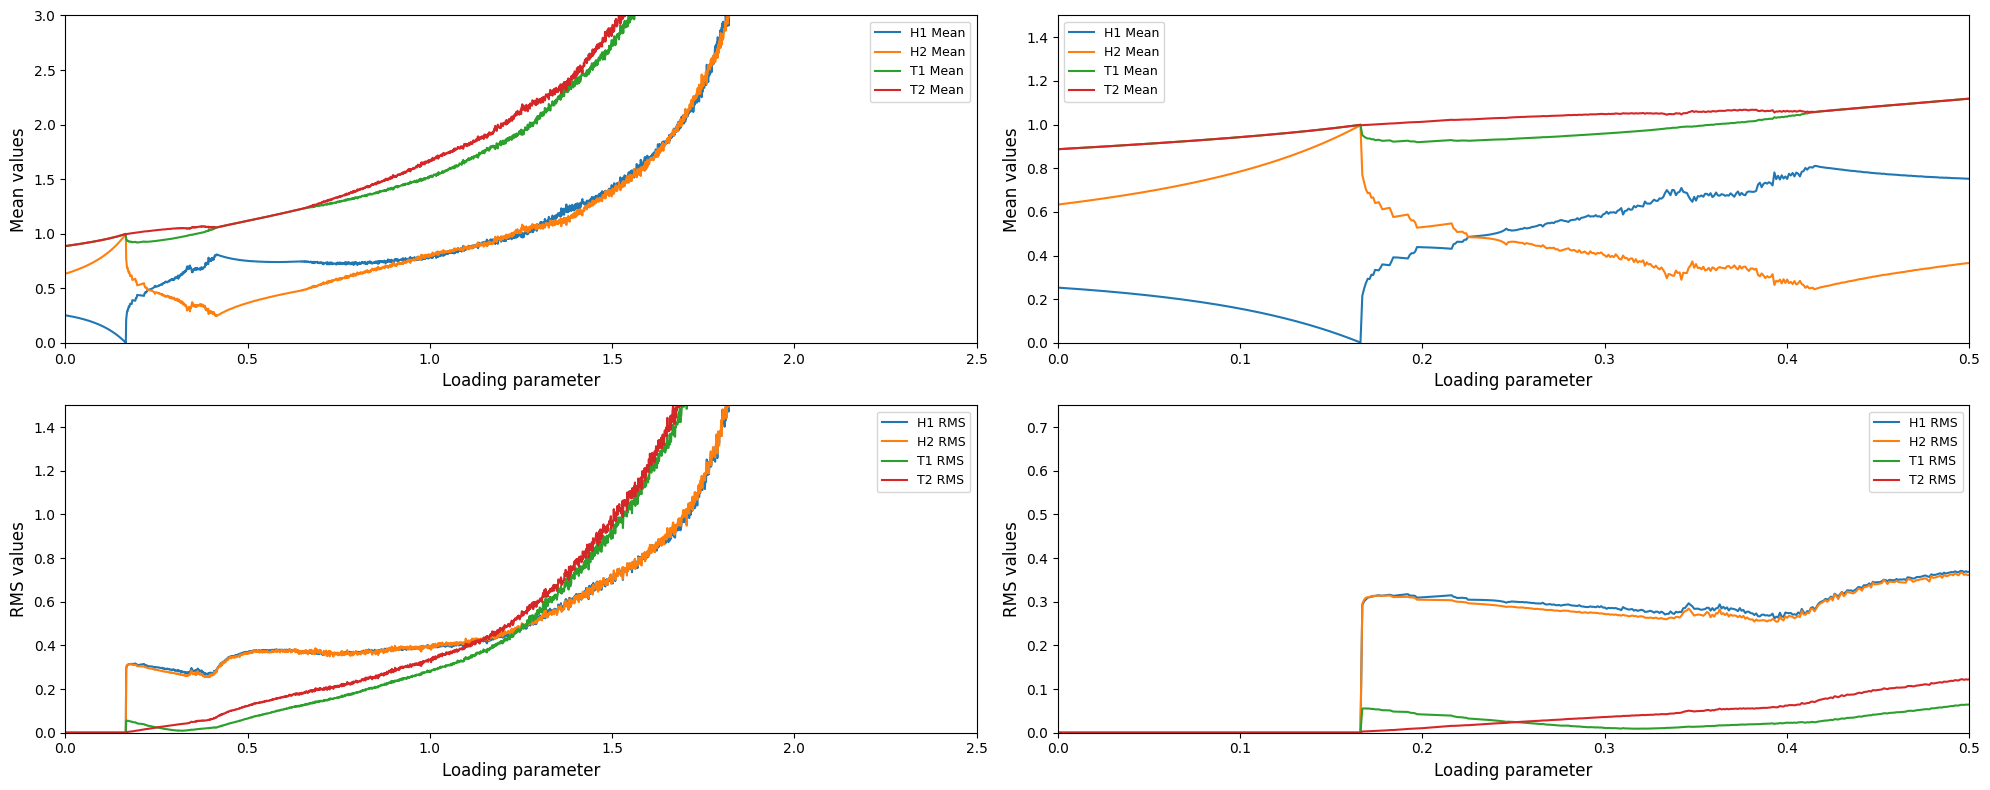

In [33]:
import matplotlib.pyplot as plt

def plot_lines(ax, x, ys, labels, xlabel, ylabel, xlim, ylim):
    for y, label in zip(ys, labels):
        ax.plot(x, y, label=label)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(fontsize=9)
    
plt.figure(figsize=(20, 8))

# Plot means with full range
plot_lines(plt.subplot(221), x,
           [h1_mean, h2_mean, t1_mean, t2_mean],
           ['H1 Mean', 'H2 Mean', 'T1 Mean', 'T2 Mean'],
           "Loading parameter", "Mean values", (0, 2.5), (0, 3))

# Plot means zoomed in
plot_lines(plt.subplot(222), x,
           [h1_mean, h2_mean, t1_mean, t2_mean],
           ['H1 Mean', 'H2 Mean', 'T1 Mean', 'T2 Mean'],
           "Loading parameter", "Mean values", (0, 0.5), (0, 1.5))

# Plot RMS with full range
plot_lines(plt.subplot(223), x,
           [h1_rms, h2_rms, t1_rms, t2_rms],
           ['H1 RMS', 'H2 RMS', 'T1 RMS', 'T2 RMS'],
           "Loading parameter", "RMS values", (0, 2.5), (0, 1.5))

# Plot RMS zoomed in
plot_lines(plt.subplot(224), x,
           [h1_rms, h2_rms, t1_rms, t2_rms],
           ['H1 RMS', 'H2 RMS', 'T1 RMS', 'T2 RMS'],
           "Loading parameter", "RMS values", (0, 0.5), (0, 0.75))

plt.tight_layout()
plt.show()

### 2.5. Phase diagram (region map) for regular and periodic (or chaotic) motions in phase space $(\Gamma, S)$ of loading and speedup parameter for $S_1 = S_2$

In [15]:
x_vals = []
y_vals = []

for S in np.linspace(0, 2, 50):
    x = []
    grad_1 = []
    grad_2 = []
    t2_rms = []
    transition_point = 0
    for gamma in tqdm(np.linspace(0, 2, 1000)):
        arrival_time = simulate_bus_system(T1_initial=T1_initial, T2_initial=T2_initial, gamma=gamma, S1=S, S2=S, num_trips=2000)
        arrival_time_2 = np.array([t[0] for t in arrival_time if t[1] == 2 and 900 <= t[2] <= 1000])
        T2 = np.abs(arrival_time_2[1:] - arrival_time_2[:-1]) if len(arrival_time_2) > 1 else np.array([])
        
        T2_mean = np.mean(T2)
        T2_rms = np.sqrt(np.mean(np.square(T2 - T2_mean)))
        t2_rms.append(T2_rms)
        x.append(gamma)
    
    print("Calculate RMS successfully\nFinding transition point")
    # Process
    x = np.array(x)
    t2_rms = np.array(t2_rms)
    for i in range(len(t2_rms) - 1):
        grad = (t2_rms[i+1] - t2_rms[i])/(x[i+1] - x[i])
        grad_1.append(grad)
    for j in range(len(grad_1) - 1):
        grad = (grad_1[j+1] - grad_1[j])/(x[j+1] - x[j])
        grad_2.append(grad)
    
    if len(grad_2) == 0:
        print(f"S = {S:.2f}: Insufficient data")
        continue

    for k in tqdm(range(2, len(grad_2) - 2)):
        
        # print(f"At index {k} -> grad_2 = {grad_2[k]} and gamma = {x[k]}")
        if grad_2[k] - grad_2[k-2] > 130:
            transition_point = x[k]
            print(f"S = {S}, transition at gamma = {transition_point}\n")
            x_vals.append(transition_point)
            y_vals.append(S)
            break

100%|██████████| 1000/1000 [00:06<00:00, 145.73it/s]


Calculate RMS successfully
Finding transition point


  0%|          | 1/994 [00:00<00:00, 2248.96it/s]


S = 0.0, transition at gamma = 0.006006006006006006



100%|██████████| 1000/1000 [00:07<00:00, 137.06it/s]


Calculate RMS successfully
Finding transition point


  2%|▏         | 17/994 [00:00<00:00, 70249.43it/s]


S = 0.04081632653061224, transition at gamma = 0.03803803803803804



100%|██████████| 1000/1000 [00:06<00:00, 144.00it/s]


Calculate RMS successfully
Finding transition point


  4%|▎         | 35/994 [00:00<00:00, 77182.25it/s]


S = 0.08163265306122448, transition at gamma = 0.07407407407407407



100%|██████████| 1000/1000 [00:06<00:00, 142.90it/s]


Calculate RMS successfully
Finding transition point


  5%|▌         | 52/994 [00:00<00:00, 66495.06it/s]


S = 0.12244897959183673, transition at gamma = 0.10810810810810811



100%|██████████| 1000/1000 [00:07<00:00, 130.99it/s]


Calculate RMS successfully
Finding transition point


  7%|▋         | 67/994 [00:00<00:00, 148372.95it/s]


S = 0.16326530612244897, transition at gamma = 0.13813813813813813



100%|██████████| 1000/1000 [00:07<00:00, 142.39it/s]


Calculate RMS successfully
Finding transition point


  8%|▊         | 82/994 [00:00<00:00, 401321.97it/s]


S = 0.2040816326530612, transition at gamma = 0.16816816816816815



100%|██████████| 1000/1000 [00:07<00:00, 140.15it/s]


Calculate RMS successfully
Finding transition point


 10%|▉         | 95/994 [00:00<00:00, 225118.01it/s]


S = 0.24489795918367346, transition at gamma = 0.1941941941941942



100%|██████████| 1000/1000 [00:07<00:00, 138.78it/s]


Calculate RMS successfully
Finding transition point


 11%|█         | 107/994 [00:00<00:00, 420215.85it/s]


S = 0.2857142857142857, transition at gamma = 0.2182182182182182



100%|██████████| 1000/1000 [00:06<00:00, 144.23it/s]


Calculate RMS successfully
Finding transition point


 12%|█▏        | 120/994 [00:00<00:00, 358998.92it/s]


S = 0.32653061224489793, transition at gamma = 0.24424424424424424



100%|██████████| 1000/1000 [00:07<00:00, 141.36it/s]


Calculate RMS successfully
Finding transition point


 13%|█▎        | 129/994 [00:00<00:00, 795684.14it/s]


S = 0.36734693877551017, transition at gamma = 0.26226226226226224



100%|██████████| 1000/1000 [00:06<00:00, 144.13it/s]


Calculate RMS successfully
Finding transition point


 14%|█▍        | 139/994 [00:00<00:00, 209263.55it/s]


S = 0.4081632653061224, transition at gamma = 0.2822822822822823



100%|██████████| 1000/1000 [00:06<00:00, 145.32it/s]


Calculate RMS successfully
Finding transition point


 15%|█▌        | 152/994 [00:00<00:00, 165938.11it/s]


S = 0.44897959183673464, transition at gamma = 0.3083083083083083



100%|██████████| 1000/1000 [00:06<00:00, 143.94it/s]


Calculate RMS successfully
Finding transition point


 16%|█▌        | 161/994 [00:00<00:00, 325437.56it/s]


S = 0.4897959183673469, transition at gamma = 0.3263263263263263



100%|██████████| 1000/1000 [00:07<00:00, 133.74it/s]


Calculate RMS successfully
Finding transition point


 17%|█▋        | 170/994 [00:00<00:00, 636635.43it/s]


S = 0.5306122448979591, transition at gamma = 0.34434434434434436



100%|██████████| 1000/1000 [00:07<00:00, 141.93it/s]


Calculate RMS successfully
Finding transition point


 18%|█▊        | 179/994 [00:00<00:00, 319209.36it/s]


S = 0.5714285714285714, transition at gamma = 0.36236236236236236



100%|██████████| 1000/1000 [00:07<00:00, 141.83it/s]


Calculate RMS successfully
Finding transition point


 19%|█▉        | 187/994 [00:00<00:00, 509308.34it/s]


S = 0.6122448979591836, transition at gamma = 0.3783783783783784



100%|██████████| 1000/1000 [00:06<00:00, 145.18it/s]


Calculate RMS successfully
Finding transition point


 20%|█▉        | 194/994 [00:00<00:00, 390261.38it/s]


S = 0.6530612244897959, transition at gamma = 0.3923923923923924



100%|██████████| 1000/1000 [00:06<00:00, 147.02it/s]


Calculate RMS successfully
Finding transition point


 20%|██        | 202/994 [00:00<00:00, 286523.30it/s]


S = 0.6938775510204082, transition at gamma = 0.4084084084084084



100%|██████████| 1000/1000 [00:06<00:00, 146.63it/s]


Calculate RMS successfully
Finding transition point


 21%|██        | 209/994 [00:00<00:00, 684316.58it/s]


S = 0.7346938775510203, transition at gamma = 0.4224224224224224



100%|██████████| 1000/1000 [00:07<00:00, 138.08it/s]


Calculate RMS successfully
Finding transition point


 22%|██▏       | 215/994 [00:00<00:00, 782791.11it/s]


S = 0.7755102040816326, transition at gamma = 0.4344344344344344



100%|██████████| 1000/1000 [00:04<00:00, 234.43it/s]


Calculate RMS successfully
Finding transition point


 22%|██▏       | 215/994 [00:00<00:00, 1778649.63it/s]


S = 0.8163265306122448, transition at gamma = 0.4344344344344344



100%|██████████| 1000/1000 [00:02<00:00, 343.12it/s]


Calculate RMS successfully
Finding transition point


 23%|██▎       | 227/994 [00:00<00:00, 2842110.47it/s]


S = 0.8571428571428571, transition at gamma = 0.45845845845845845



100%|██████████| 1000/1000 [00:02<00:00, 340.17it/s]


Calculate RMS successfully
Finding transition point


 23%|██▎       | 233/994 [00:00<00:00, 2677459.81it/s]


S = 0.8979591836734693, transition at gamma = 0.47047047047047047



100%|██████████| 1000/1000 [00:02<00:00, 346.99it/s]


Calculate RMS successfully
Finding transition point


 24%|██▍       | 239/994 [00:00<00:00, 1681944.05it/s]


S = 0.9387755102040816, transition at gamma = 0.4824824824824825



100%|██████████| 1000/1000 [00:02<00:00, 347.21it/s]


Calculate RMS successfully
Finding transition point


 25%|██▍       | 244/994 [00:00<00:00, 2430903.03it/s]


S = 0.9795918367346939, transition at gamma = 0.4924924924924925



100%|██████████| 1000/1000 [00:02<00:00, 349.82it/s]


Calculate RMS successfully
Finding transition point


 25%|██▌       | 249/994 [00:00<00:00, 2384433.10it/s]


S = 1.0204081632653061, transition at gamma = 0.5025025025025025



100%|██████████| 1000/1000 [00:02<00:00, 338.14it/s]


Calculate RMS successfully
Finding transition point


 26%|██▌       | 254/994 [00:00<00:00, 2637012.91it/s]


S = 1.0612244897959182, transition at gamma = 0.5125125125125125



100%|██████████| 1000/1000 [00:02<00:00, 341.55it/s]


Calculate RMS successfully
Finding transition point


 26%|██▌       | 259/994 [00:00<00:00, 2199037.93it/s]


S = 1.1020408163265305, transition at gamma = 0.5225225225225225



100%|██████████| 1000/1000 [00:02<00:00, 336.91it/s]


Calculate RMS successfully
Finding transition point


 26%|██▋       | 263/994 [00:00<00:00, 2171460.54it/s]


S = 1.1428571428571428, transition at gamma = 0.5305305305305306



100%|██████████| 1000/1000 [00:03<00:00, 324.44it/s]


Calculate RMS successfully
Finding transition point


 27%|██▋       | 268/994 [00:00<00:00, 1662830.58it/s]


S = 1.183673469387755, transition at gamma = 0.5405405405405406



100%|██████████| 1000/1000 [00:03<00:00, 323.60it/s]


Calculate RMS successfully
Finding transition point


 27%|██▋       | 272/994 [00:00<00:00, 2401790.92it/s]


S = 1.2244897959183672, transition at gamma = 0.5485485485485485



100%|██████████| 1000/1000 [00:02<00:00, 335.61it/s]


Calculate RMS successfully
Finding transition point


 28%|██▊       | 276/994 [00:00<00:00, 2625006.59it/s]


S = 1.2653061224489794, transition at gamma = 0.5565565565565566



100%|██████████| 1000/1000 [00:02<00:00, 339.11it/s]


Calculate RMS successfully
Finding transition point


 28%|██▊       | 280/994 [00:00<00:00, 1993896.64it/s]


S = 1.3061224489795917, transition at gamma = 0.5645645645645646



100%|██████████| 1000/1000 [00:02<00:00, 344.99it/s]


Calculate RMS successfully
Finding transition point


 29%|██▊       | 284/994 [00:00<00:00, 2802781.97it/s]


S = 1.346938775510204, transition at gamma = 0.5725725725725725



100%|██████████| 1000/1000 [00:02<00:00, 343.42it/s]


Calculate RMS successfully
Finding transition point


 29%|██▉       | 287/994 [00:00<00:00, 3009413.12it/s]


S = 1.3877551020408163, transition at gamma = 0.5785785785785785



100%|██████████| 1000/1000 [00:02<00:00, 348.94it/s]


Calculate RMS successfully
Finding transition point


 29%|██▉       | 291/994 [00:00<00:00, 2991525.65it/s]


S = 1.4285714285714284, transition at gamma = 0.5865865865865866



100%|██████████| 1000/1000 [00:02<00:00, 345.76it/s]


Calculate RMS successfully
Finding transition point


 30%|██▉       | 294/994 [00:00<00:00, 2574374.48it/s]


S = 1.4693877551020407, transition at gamma = 0.5925925925925926



100%|██████████| 1000/1000 [00:02<00:00, 344.92it/s]


Calculate RMS successfully
Finding transition point


 30%|██▉       | 297/994 [00:00<00:00, 1928341.00it/s]


S = 1.510204081632653, transition at gamma = 0.5985985985985985



100%|██████████| 1000/1000 [00:02<00:00, 335.28it/s]


Calculate RMS successfully
Finding transition point


 30%|███       | 301/994 [00:00<00:00, 2587060.46it/s]


S = 1.5510204081632653, transition at gamma = 0.6066066066066066



100%|██████████| 1000/1000 [00:02<00:00, 339.29it/s]


Calculate RMS successfully
Finding transition point


 31%|███       | 304/994 [00:00<00:00, 3228021.31it/s]


S = 1.5918367346938773, transition at gamma = 0.6126126126126126



100%|██████████| 1000/1000 [00:03<00:00, 319.92it/s]


Calculate RMS successfully
Finding transition point


 31%|███       | 307/994 [00:00<00:00, 2524806.53it/s]


S = 1.6326530612244896, transition at gamma = 0.6186186186186187



100%|██████████| 1000/1000 [00:02<00:00, 333.37it/s]


Calculate RMS successfully
Finding transition point


 31%|███       | 310/994 [00:00<00:00, 2514959.85it/s]


S = 1.673469387755102, transition at gamma = 0.6246246246246246



100%|██████████| 1000/1000 [00:02<00:00, 334.74it/s]


Calculate RMS successfully
Finding transition point


 31%|███▏      | 312/994 [00:00<00:00, 3296279.21it/s]


S = 1.7142857142857142, transition at gamma = 0.6286286286286287



100%|██████████| 1000/1000 [00:03<00:00, 331.75it/s]


Calculate RMS successfully
Finding transition point


 32%|███▏      | 315/994 [00:00<00:00, 2176615.75it/s]


S = 1.7551020408163265, transition at gamma = 0.6346346346346347



100%|██████████| 1000/1000 [00:02<00:00, 337.44it/s]


Calculate RMS successfully
Finding transition point


 32%|███▏      | 318/994 [00:00<00:00, 2694522.57it/s]


S = 1.7959183673469385, transition at gamma = 0.6406406406406406



100%|██████████| 1000/1000 [00:02<00:00, 336.63it/s]


Calculate RMS successfully
Finding transition point


 32%|███▏      | 320/994 [00:00<00:00, 2354696.98it/s]


S = 1.8367346938775508, transition at gamma = 0.6446446446446447



100%|██████████| 1000/1000 [00:02<00:00, 343.55it/s]


Calculate RMS successfully
Finding transition point


 32%|███▏      | 323/994 [00:00<00:00, 2323773.91it/s]


S = 1.8775510204081631, transition at gamma = 0.6506506506506506



100%|██████████| 1000/1000 [00:02<00:00, 343.79it/s]


Calculate RMS successfully
Finding transition point


 33%|███▎      | 325/994 [00:00<00:00, 3222574.00it/s]


S = 1.9183673469387754, transition at gamma = 0.6546546546546547



100%|██████████| 1000/1000 [00:03<00:00, 330.16it/s]


Calculate RMS successfully
Finding transition point


 33%|███▎      | 328/994 [00:00<00:00, 2020164.04it/s]


S = 1.9591836734693877, transition at gamma = 0.6606606606606606



100%|██████████| 1000/1000 [00:03<00:00, 329.78it/s]


Calculate RMS successfully
Finding transition point


 33%|███▎      | 330/994 [00:00<00:00, 2708650.33it/s]

S = 2.0, transition at gamma = 0.6646646646646647



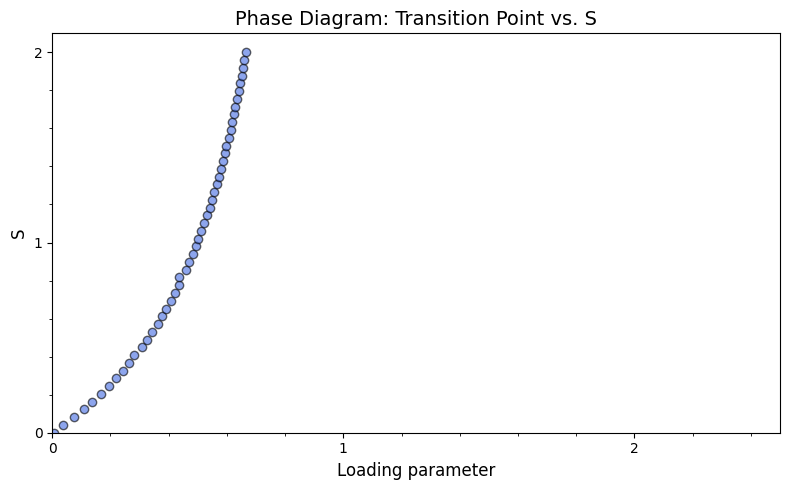

In [35]:
import matplotlib.ticker as ticker
# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x_vals, y_vals, alpha=0.6, color='royalblue', edgecolors='black')
plt.xlabel("Loading parameter", fontsize=12)
plt.ylabel("S", fontsize=12)
plt.title("Phase Diagram: Transition Point vs. S", fontsize=14)
plt.xlim(0, 2.5)
plt.ylim(0, 2.1)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.xticks([0, 1, 2])
plt.yticks([0, 1, 2])
plt.minorticks_on()
plt.tight_layout()
plt.show()

### Future Research

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [39]:
x = np.array(x_vals).reshape(-1, 1)
y = np.array(y_vals)

poly = PolynomialFeatures(degree=4)
x_poly = poly.fit_transform(x)

scaler = StandardScaler()
x_poly_scaled = scaler.fit_transform(x_poly)

model = LinearRegression()
model.fit(x_poly_scaled, y)

LinearRegression()

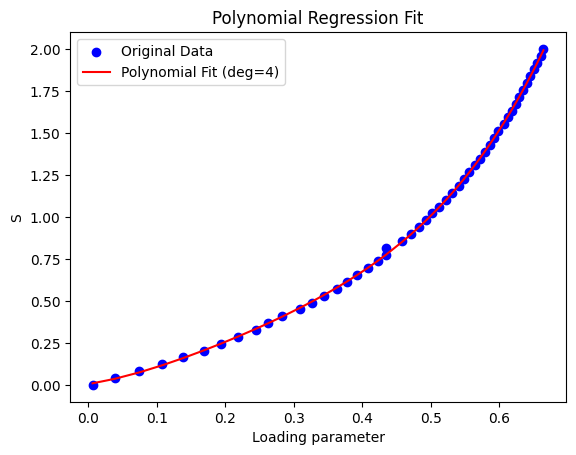

In [40]:
y_pred = model.predict(x_poly_scaled)

plt.scatter(x, y, color='blue', label="Original Data")
plt.plot(x, y_pred, color='red', label="Polynomial Fit (deg=4)")
plt.xlabel("Loading parameter")
plt.ylabel("S")
plt.title("Polynomial Regression Fit")
plt.legend()
plt.show()

In [41]:
print("Intercept", model.intercept_)
print("Coefficients", model.coef_)

Intercept 1.0000000000000007
Coefficients [ 0.          0.11620866  0.65336317 -0.9998041   0.83656908]
